# Weighted Condorcet's Jury Theorem

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import norm
import csv

## The Environment

Consider a person who is suspected of having a hypothethical disease. He/She is tested using a machine which sends a signal $S$ depending on the precence or absence of the disease. Now, in an ideal world, the signal $S$ would have been a binary function which would have assumed one particular value for the presence of the disease and another value for the absence of the disease. However, in reality, the signal sent by the machine is actually a random variable which maybe drawn from one normal distribution if the disease is present, or from another normal distribution if the disease is absent.

Suppose the probability of the person having the disease is $p$. Therefore, the signal sent is,

$$ S \sim p \cdot \mathcal{N}\left(\mu_p, \sigma^2\right) + \left(1-p\right) \cdot \mathcal{N}\left(\mu_n, \sigma^2\right) $$

where,
- $p$ is the probability that the disease is present (also known as the __prior__
- $\mu_p$ is the mean signal if the disease is present
- $\mu_n$ is the mean signal if the disease is absent
- $\sigma$ is the standard deviation of the signal sent in either case
- $\mathcal{N}\left(\mu,\sigma^2\right)$ is the normal distribution with mean $\mu$ and standard deviation $\sigma$.

In [4]:
class Environment:
    
    def __init__(self, N_exp, prior, μ_p, μ_n, σ):
        
        self.N_exp = N_exp
        self.prior = prior
        self.μ_p = μ_p
        self.μ_n = μ_n
        self.σ = σ
        
        self.event = [True if np.random.random() < prior else False for i in range(N_exp)]
        self.signal = [μ_p + σ*(np.random.randn()) if self.event[i] else μ_n + σ*(np.random.randn()) for i in range(N_exp)]

## The Perfect Decision Making Agents

The signal $S$ is received by $N$ decision making agents (or simply, agents). Each agent $i$ decides, on the basis of the signal received, whether the patient has the disease or not. This is done on the basis of a threshold $T_i$: if the percieved signal strength is greater than the threshold $T_i$, then the agent decides that the patient has the disease; else the agent decides that the patient does not have the disease.

Since the signal $S$ comes from normal distributions, the decisions of the agents will not always be accurate. Let $a_{p,i}$ be the probability that agent $i$ would make the correct decision if the desease is present. Similarly, let $a_{n,i}$ be the probability that agent $i$ would make the correct decision if the desease is not present. Then,

$$ a_{p,i} = 1 - \Phi\left( T_i, \mu_p, \sigma \right) $$
and
$$ a_{n,i} = \Phi\left( T_i, \mu_n, \sigma \right) $$

where $\Phi\left( x, \mu, \sigma \right)$ is the value CDF of a normal distribution with mean $\mu$ and standard deviation $\sigma$ at point $x$.

In [5]:
def get_accuracy(x, μ_p, μ_n, σ):
    a_p = 1 - norm.cdf(x,μ_p,σ)
    a_n = norm.cdf(x,μ_n,σ)
    return (a_p, a_n)

### Reward Matrix

In order to determine the threshold $T_i$, it is important to consider the rewards of making a decision. There are four possible scenarios regarding the correctness of the decision. Each of these scenarios has its corresponding reward:

$\downarrow$ Decision/Environment $\rightarrow$ | Positive | Negative
------------------------------------------------|----------|----------
Positive                                        | $R_{TP}$ | $R_{FP}$
Negative                                        | $R_{FN}$ | $R_{TN}$

### The Expected Reward

Combing the aforementioned reward matrix, the accuracies of the agents and the priors, we get the expected reward for a given threshold to be,

$$ E_i = p \cdot \left[ a_{p,i} \cdot R_{TP} + \left(1-a_{p,i} \right) \cdot R_{FN} \right] + \left[1-p \right] \cdot \left[ a_{n,i} \cdot R_{TN} + \left(1-a_{n,i} \right) \cdot R_{FP} \right] $$

In [6]:
def get_expected_reward(p, μ_p, μ_n, σ, R, x_min=None, x_max=None, n_points=None):

    assert μ_p > μ_n
    
    x_min = μ_n - 6*σ if x_min == None else x_min
    x_max = μ_p + 6*σ if x_max == None else x_max
    n_points = 10000 if n_points == None else n_points
    
    assert x_max > x_min
    
    xs = np.linspace(x_min, x_max, n_points)
    ys = np.zeros(len(xs))
    
    for i in range(len(xs)):
        (a_p, a_n) = get_accuracy(xs[i], μ_p, μ_n, σ)
        ys[i] = p*(a_p*R['tp']+(1-a_p)*R['fn']) + (1-p)*(a_n*R['tn']+(1-a_n)*R['fp'])
    
    return (xs, ys)

### Finding the Threshold

The agents choose the threshold such that the expected reward is the maximum, _i. e._,
$$ \dfrac{\partial E_i}{\partial T_i} = 0 $$
and
$$ \dfrac{\partial^2 E_i}{\partial T_i^2} < 0. $$

In [7]:
def get_optimized_threshold(x,y):
    
    assert len(x) == len(y)
    
    r = []
    for ii in range(1,len(x)-1):
        if y[ii] > y[ii+1] and y[ii] > y[ii-1]:
            a = {'threshold': x[ii], 
                 'reward': y[ii],
                 'index': ii
                }
            r.append(a)
            
    if len(r) == 0:
        print('No maximas found')
        return
    if len(r) > 1:
        print('Multiple maximas found')
    
    return r[0]

## The Imperfect Decision Maker

During this decision process, the agent can make the following two types errors:

- Error in percieving the ideal signal strengths $\mu_p$ and $\mu_n$.
- Error in percieving sent signal strength $S$.

Let us assume that the percieved ideal signal signal strengths are $\tilde{\mu}_{p,i}$ and $\tilde{\mu}_{n,i}$, and the percieved signal strength is $\tilde{S}_i$. Then,

$$ \tilde{\mu}_{p,i} = \mu_p + \epsilon_i $$
$$ \tilde{\mu}_{n,i} = \mu_n + \epsilon_i $$
and
$$ \tilde{S}_{i} = S + \zeta_i $$

where, $ \epsilon_i \sim \mathcal{N} \left( 0, e_{\mu}^2 \right) $ and $ \zeta_i \sim \mathcal{N} \left( 0, e_{S}^2 \right) $ are the errors in determining the means and the signal respectively. 

In [8]:
class Agent:
    
    def __init__(self, idx, p, μ_p, μ_n, σ, R, err_μ=0):
        
        self.index = idx
        self.μ_p_prime = μ_p + err_μ*np.random.randn()
        self.μ_n_prime = μ_n + err_μ*np.random.randn()
        
        xx, yy = get_expected_reward(p, self.μ_p_prime, self.μ_n_prime, σ, R)
        opt = get_optimized_threshold(xx, yy)
        self.threshold_prime = opt['threshold']
        
        a_p, a_n = get_accuracy(self.threshold_prime, self.μ_p_prime, self.μ_n_prime, σ)
        self.accuracy_p = a_p
        self.accuracy_n = a_n
        
    def decide(self, S, err_S=0):
        
        self.S_prime = S + err_S*np.random.randn()
        self.decision = self.S_prime > self.threshold_prime

## Functions to run the code

### Parameters

We start by setting the default parameters of the system.

In [9]:
def set_parameters(p=0.5, μ_p=1, μ_n=-1, σ=0.3, R_tp=1, R_fn=0, R_tn=1, R_fp=0, No_of_exp=100, No_of_agents=100, err_μ=0.05, err_S=0.02):

    params = {}
    
    params['p'] = p

    params['μ_p'] = μ_p
    params['μ_n'] = μ_n
    params['σ'] = σ

    params['R'] = {'tp': R_tp, 'fn': R_fn, 'tn': R_tn, 'fp': R_fp}

    params['N_agents'] = No_of_agents
    params['N_experiments'] = No_of_exp

    params['err_μ'] = err_μ
    params['err_s'] = err_S

    return params

### Ideal Agent

In [10]:
def get_ideal_parameters(p, μ_p, μ_n, σ, R):
    xx, yy = (get_expected_reward(p, μ_p, μ_n, σ, R))
    ideal_parameters = get_optimized_threshold(xx, yy)
    return ideal_parameters

### Create Environment

In [11]:
def create_environment(N_experiments, p, μ_p, μ_n, σ):
    env = Environment(N_experiments, p, μ_p, μ_n, σ)
    return env

### Create agents

In [12]:
def create_agents(N_agents, p, μ_p, μ_n, σ, R, err_μ):
    agents = []
    for i in tqdm(range(N_agents)):
        a = Agent(i, p, μ_p, μ_n, σ, R, err_μ)
        agents.append(a)
    return agents

### Make Decisions

In [13]:
def make_decisions(env, agents, err_S):
    
    N_experiments = env.N_exp
    N_agents = len(agents)
    
    ss = np.zeros((N_experiments, N_agents))
    dd = np.zeros((N_experiments, N_agents))

    for i in range(N_experiments):
    
        current_signal = env.signal[i]
    
        for j in range(N_agents):
            agents[j].decide(current_signal, err_S)

            ss[i,j] = agents[j].S_prime
            dd[i,j] = agents[j].decision
            
    return (ss, dd)

### Combine decisions

In [14]:
def combine_decisions(env, agents, decisions, p, R):
    
    cd = [True]*env.N_exp
    
    for i in range(env.N_exp):
        
        combined_decision = np.log(p/(1-p)) + np.log((R['tp']-R['fn'])/(R['tn']-R['fp']))
        
        for j in range(len(agents)):
            
            x = 1 if decisions[i,j] == 1 else -1
            
            β_p = np.log(agents[j].accuracy_p/(1-agents[j].accuracy_p))
            β_n = np.log(agents[j].accuracy_n/(1-agents[j].accuracy_n))
            
            ψ = 0.5 * np.log((agents[j].accuracy_p*(1-agents[j].accuracy_p))/(agents[j].accuracy_n*(1-agents[j].accuracy_n)))
            
            combined_decision += 0.5 * (β_p + β_n) * x + ψ
            
        if combined_decision > 1:
            cd[i] = True
        else:
            cd[i] = False
            
    return cd

### Get Rewarded

In [15]:
def get_group_reward(env, group_decisions, R):
    
    reward = np.zeros(env.N_exp)
    for i in range(env.N_exp):

        if env.event[i] == True and group_decisions[i] == True:
            reward[i] += R['tp']
        elif env.event[i] == True and group_decisions[i] == False:
            reward[i] += R['fn']
        elif env.event[i] == False and group_decisions[i] == True:
            reward[i] += R['fp']
        elif env.event[i] == False and group_decisions[i] == False:
            reward[i] += R['tn']
            
    return reward

## Running the Code

In [14]:
N_points = 100

prob_list = np.linspace(0,1,N_points)

data_ideal = np.zeros(N_points)
data_mean = np.zeros(N_points)
data_std = np.zeros(N_points)

for count in range(len(prob_list)):    
    try:
    
        env = create_environment(N_experiments=params['N_experiments'], p=params['p'], μ_p=params['μ_p'], μ_n=params['μ_n'], σ=params['σ'])
        agents = create_agents(N_agents=params['N_agents'], p=params['p'], μ_p=params['μ_p'], μ_n=params['μ_n'], σ=params['σ'], R=params['R'], err_μ=params['err_μ'])

        individual_signals, individual_decisions = make_decisions(env, agents, params['err_s'])
        group_decisions = combine_decisions(env, agents, individual_decisions, params['p'], params['R'])
        group_rewards = get_group_reward(env, group_decisions, params['R'])

        ideal = get_ideal_parameters(p=params['p'], μ_p=params['μ_p'], μ_n=params['μ_n'], σ=params['σ'], R=params['R'])

        mean_group_rewards = np.mean(group_rewards)
        std_group_rewards = np.std(group_rewards)

        data_ideal[count] = ideal['reward']
        data_mean[count] = mean_group_rewards
        data_std[count] = std_group_rewards
    
    except:
        
        pass

  0%|          | 0/100 [00:00<?, ?it/s]

No maximas found


  0%|          | 0/100 [00:00<?, ?it/s]

No maximas found


## Save Data

In [34]:
data_dict = []

for i in range(100):
    
    d = {}
    d['prior'] = prob_list[i]
    d['ideal_agent'] = data_ideal[i]
    d['mean_group'] = data_mean[i]
    d['std_group'] = data_std[i]
    
    data_dict.append(d)

with open("prior_scan_data.csv", "w") as file:
    writer = csv.DictWriter(file, d.keys())
    writer.writeheader()
    for i in range(len(data_dict)):
        writer.writerow(data_dict[i])

## Results

### Prior Scan

#### Retrieve Data

In [61]:
reader = csv.DictReader(open("prior_scan_data.csv", "r"))

prob_list = []
data_ideal = []
data_mean = []
data_std = []

for line in reader:
    prob_list.append(float(line['prior']))
    data_ideal.append(float(line['ideal_agent']))
    data_mean.append(float(line['mean_group']))
    data_std.append(float(line['std_group']))

#### Plot

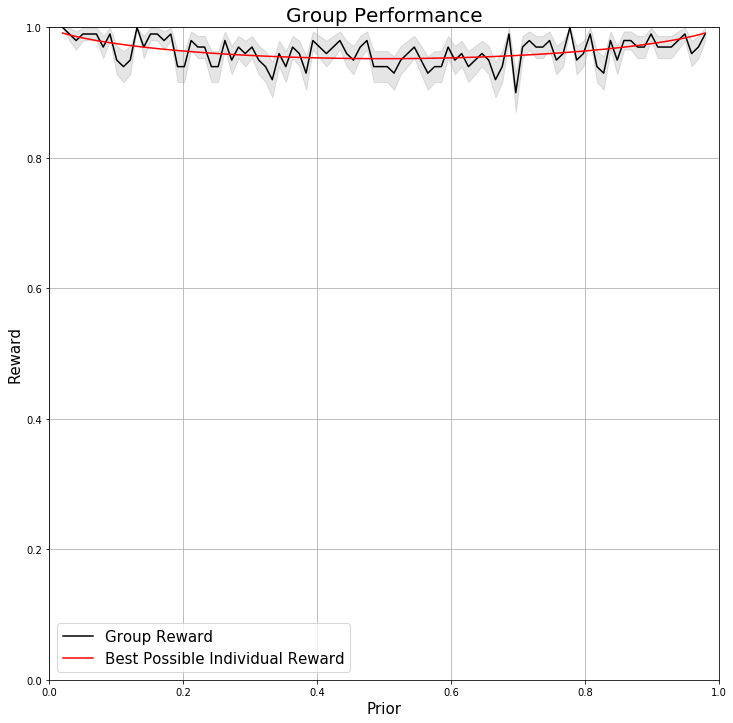

In [63]:
prob_list = prob_list[1:-1]
data_mean = data_mean[1:-1]
data_std = data_std[1:-1]
data_ideal = data_ideal[1:-1]

plt.figure(figsize=(12,12))

plt.title("Group Performance", fontsize=20)
plt.xlabel("Prior", fontsize=15)
plt.ylabel("Reward", fontsize=15)

plt.xlim((0,1))
plt.ylim((0,1))

plt.plot(prob_list,data_mean,'k',label="Group Reward")
plt.fill_between(prob_list,data_mean+data_std/np.sqrt(100),data_mean-data_std/np.sqrt(100),color='k',alpha=0.1)
plt.plot(prob_list,data_ideal,color='r', label="Best Possible Individual Reward")

plt.legend(fontsize=15)
plt.grid()
plt.show()